Notebook for testing the trained models.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
import pandas as pd
import torch.nn.functional as F

from lib.utils import get_free_gpu, load_lizard, debug
from lib.utils_vis import make_seed, to_rgb, damage_batch
from lib.EnergyCAModel import EnergyCAModel
from lib.CAModel import CAModel
from lib.utils import animate_steps
model_dir = 'models/'

# Initialization

In [2]:

torch.backends.cudnn.benchmark = True # Speeds up stuff
torch.backends.cudnn.enabled = True

## General Parameters ##
global_params = {
    'CHANNEL_N': 16,
    'TARGET_PADDING': 16,
    'TARGET_SIZE': 40,
    'IMG_SIZE': 72,
    'MIN_STEPS': 64,
    'MAX_STEPS': 128,
}

## General Training Parameters ##
# choose cuda device with the least amount of current memory usage
training_params = {
    'lr': 2e-3,
    'lr_gamma': 0.9999,
    'betas': (0.5, 0.5),
    'n_epoch': 10000,
    'batch_size': 8,
    'grad_clip': 1.0,
    'device': torch.device('cuda:{}'.format(get_free_gpu(min_free_mem=0.8)) if torch.cuda.is_available() else 'cpu'),
    'history_save_dir': 'histories/',
    'model_save_dir': 'models/gumbel/', ###
}

ca_params = {"CELL_FIRE_RATE": 0.5}
number_of_batches = 10#10
beta_constFireRate_correspondance = {
    0: 0.958,
    1e-9: 0.634,
    5e-9: 0.278,
    2e-9: 0.471,
    5e-10: 0.634,
    2e-10: 0.689, ###
}


Getting free GPU...
| ID | GPU | MEM |
------------------
|  0 |  0% |  7% |
|  1 | 92% | 96% |
|  2 | 96% | 74% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
Using GPU:  0


/nfs_home/charneca/miniconda3/envs/nca/lib/python3.9/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU4 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


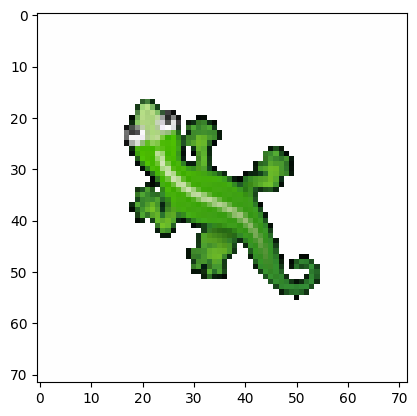

In [3]:
# Load target emoji
target_img = load_lizard('data/lizard_clean.png')
p = global_params['TARGET_PADDING']
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))

# Create initial state
seed = make_seed((h, w), global_params['CHANNEL_N'])
x0 = np.repeat(seed[None, ...], training_params["batch_size"], 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(training_params['device'])

plt.imshow(to_rgb(pad_target.detach().cpu()[0]))

# Load csv

In [4]:
# load csvs from test_losses
all_files = [f for f in os.listdir('test_losses') if f.endswith('maxSteps128_epoch10000.csv')]
energyca_files = [f for f in all_files if f.startswith('EnergyCA')]
ca_files = [f for f in all_files if f.startswith('CA')]

ca_data = [
    {
        "loss": pd.read_csv(os.path.join('test_losses', f))['loss'].values,
        "loss_stderror": pd.read_csv(os.path.join('test_losses', f))['loss_stderror'].values,
        "constFireRate": float(f.split("constFireRate")[1].split('_')[0])
    }
    for f in ca_files if float(f.split("constFireRate")[1].split('_')[0]) in beta_constFireRate_correspondance.values()
]
energyca_data = [
    {
        "loss": pd.read_csv(os.path.join('test_losses', f))['loss'].values,
        "loss_stderror": pd.read_csv(os.path.join('test_losses', f))['loss_stderror'].values,
        "avg_fireRate":  pd.read_csv(os.path.join('test_losses', f))['avg_fireRate'].values,
        "betaEnergy": float(f.split("betaEnergy")[1].split('_')[0])
    }
    for f in energyca_files if float(f.split("betaEnergy")[1].split('_')[0]) in beta_constFireRate_correspondance.keys()
]

ca_data = sorted(ca_data, key=lambda x: x["constFireRate"])
energyca_data = sorted(energyca_data, key=lambda x: float(x["betaEnergy"]))

In [5]:
# Load histories
all_histories = [f for f in os.listdir('histories') if f.endswith('maxSteps128_history.csv')]
energyca_histories = [f for f in all_histories if f.startswith('EnergyCA')]
ca_histories = [f for f in all_histories if f.startswith('CA')]

ca_hist_data = [
    {
        "loss": pd.read_csv(os.path.join('histories', f))['loss'].values,
        "constFireRate": float(f.split("constFireRate")[1].split('_')[0])
    }
    for f in ca_histories if float(f.split("constFireRate")[1].split('_')[0]) in beta_constFireRate_correspondance.values()
]
energyca_hist_data = [
    {
        "loss": pd.read_csv(os.path.join('histories', f))['loss'].values,
        "loss_rec_val": pd.read_csv(os.path.join('histories', f))['loss_rec_val'].values,
        "loss_energy_val": pd.read_csv(os.path.join('histories', f))['loss_energy_val'].values,
        "betaEnergy": float(f.split("betaEnergy")[1].split('_')[0])
    }
    for f in energyca_histories if float(f.split("betaEnergy")[1].split('_')[0]) in beta_constFireRate_correspondance.keys()
]

energyca_hist_data = sorted(energyca_hist_data, key=lambda x: float(x['betaEnergy']))
ca_hist_data = sorted(ca_hist_data, key=lambda x: x['constFireRate'])


In [6]:
# Load damage data
damage_location = 'center'
all_damage = [f for f in os.listdir(f'damage_losses/{damage_location}') if f.endswith('maxSteps128_epoch10000.csv')]
energyca_damage = [f for f in all_damage if f.startswith('EnergyCA')]
ca_damage = [f for f in all_damage if f.startswith('CA')]

ca_damage_data = [
    {
        "loss": pd.read_csv(os.path.join(f'damage_losses/{damage_location}', f))['loss'].values,
        "loss_stderror": pd.read_csv(os.path.join(f'damage_losses/{damage_location}', f))['loss_stderror'].values,
        "constFireRate": float(f.split("constFireRate")[1].split('_')[0])
    }
    for f in ca_damage if float(f.split("constFireRate")[1].split('_')[0]) in beta_constFireRate_correspondance.values()
]
energyca_damage_data = [
    {
        "loss": pd.read_csv(os.path.join(f'damage_losses/{damage_location}', f))['loss'].values,
        "loss_stderror": pd.read_csv(os.path.join(f'damage_losses/{damage_location}', f))['loss_stderror'].values,
        "avg_fireRate":  pd.read_csv(os.path.join(f'damage_losses/{damage_location}', f))['avg_fireRate'].values,
        "betaEnergy": float(f.split("betaEnergy")[1].split('_')[0])
    }
    for f in energyca_damage if float(f.split("betaEnergy")[1].split('_')[0]) in beta_constFireRate_correspondance.keys()
]

energyca_damage_data = sorted(energyca_damage_data, key=lambda x: float(x['betaEnergy']))
ca_damage_data = sorted(ca_damage_data, key=lambda x: x['constFireRate'])


# Plots

## Training plots

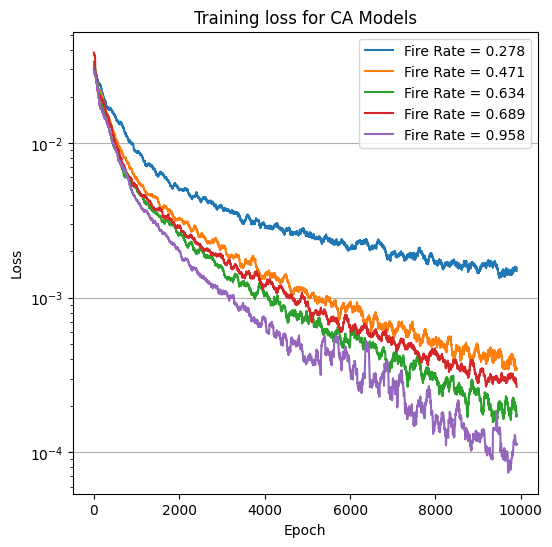

In [7]:
# plot ca loss history
plt.figure(figsize=(6,6))
# we'll use np.convolve to smooth the data
window_size = 100
filter = np.ones(window_size)/window_size

for data in ca_hist_data:
    plt.plot(np.convolve(data["loss"], filter, mode="valid"), label = "Fire Rate = {}".format(data['constFireRate']))

plt.title(f"Training loss for CA Models")
plt.legend()
plt.yscale('log')
plt.grid(axis='y')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


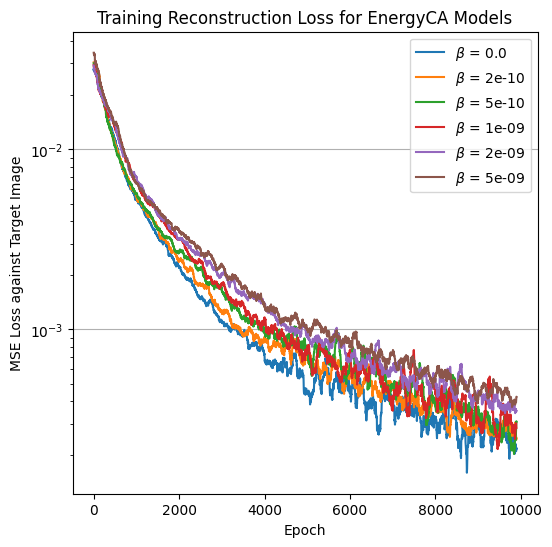

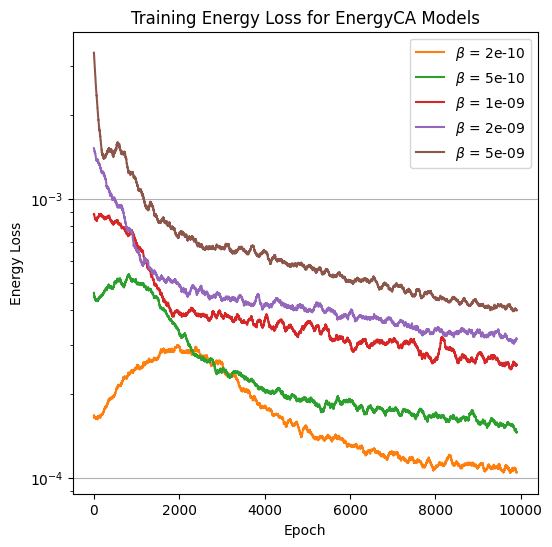

In [8]:
# plot energyca loss history, with loss_rec_val and loss_energy_val in different axes
window_size = 100
filter = np.ones(window_size)/window_size

# plot loss_rec_val
plt.figure(figsize=(6,6))
for data in energyca_hist_data:
    plt.plot(np.convolve(data["loss_rec_val"], filter, mode="valid"), label =r"$\beta$ = {}".format(data['betaEnergy']))

plt.title(f"Training Reconstruction Loss for EnergyCA Models")
plt.legend()
plt.yscale('log')
plt.grid(axis='y')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss against Target Image")
plt.show()

# plot loss_energy_val
plt.figure(figsize=(6,6))
for data in energyca_hist_data:
    if data['betaEnergy'] != 0:
        plt.plot(np.convolve(data["loss_energy_val"], filter, mode="valid"), label =r"$\beta$ = {}".format(data['betaEnergy']))
    else:
        plt.plot(np.convolve(data["loss_energy_val"], filter, mode="valid")*0)

plt.title(f"Training Energy Loss for EnergyCA Models")
plt.legend()
plt.yscale('log')
plt.grid(axis='y')
plt.xlabel("Epoch")
plt.ylabel("Energy Loss")
plt.show()

## EnergyCA persistance plots

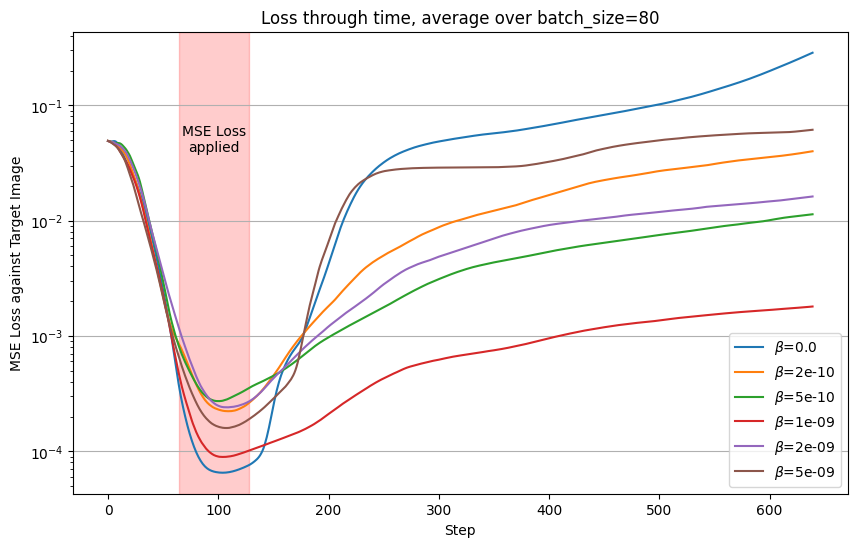

In [9]:
plt.figure(figsize=(10,6))
for data in energyca_data:
    plt.plot(data["loss"], label=r"$\beta$={}".format(data["betaEnergy"]))
    #plt.fill_between(np.arange(len(data["loss"])), data["loss"]-data["loss_stderror"], data["loss"]+data["loss_stderror"], alpha=0.2)

# add a colored band between x = global_params["MIN_STEPS"] and x = global_params["MAX_STEPS"]
plt.axvspan(global_params["MIN_STEPS"], global_params["MAX_STEPS"], alpha=0.2, color='red')
plt.text(96, 4e-2, "MSE Loss\napplied", fontsize=10, horizontalalignment='center')


plt.legend()
plt.title(f"Loss through time, average over batch_size={number_of_batches*training_params['batch_size']}")
plt.yscale('log')
plt.ylabel("MSE Loss against Target Image")
plt.xlabel("Step")
plt.grid(axis='y')
#plt.ylim([0,0.1])
plt.show()

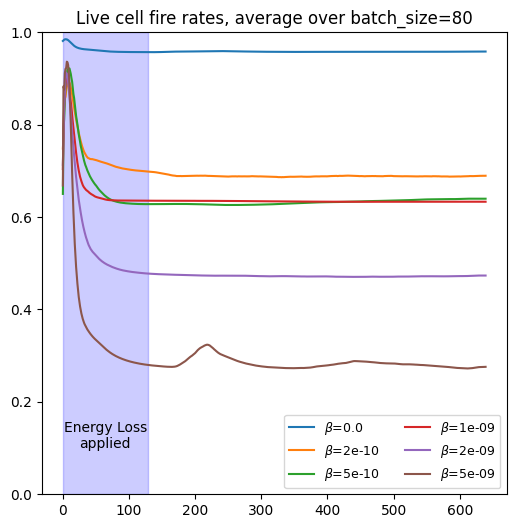

In [10]:
# plot average fire rate
plt.figure(figsize=(6,6))

for data in energyca_data:
    plt.plot(data["avg_fireRate"], label=r"$\beta$={}".format(data["betaEnergy"]))
    
plt.axvspan(0, global_params["MAX_STEPS"], alpha=0.2, color='blue')
plt.text(64, 0.1, "Energy Loss\napplied", fontsize=10, horizontalalignment='center')

plt.legend(fontsize=9, ncol = 2, loc='lower right')
plt.title(f"Live cell fire rates, average over batch_size={number_of_batches*training_params['batch_size']}")
plt.ylim([0,1])
plt.show()

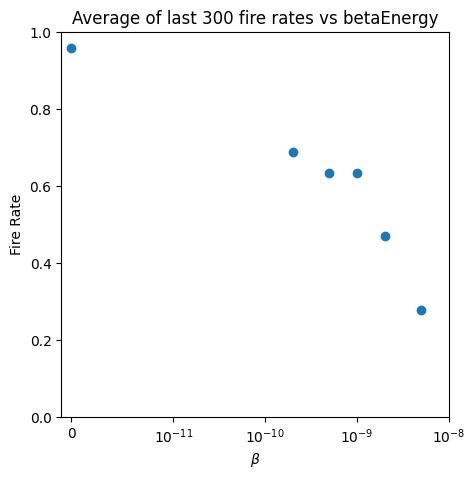

In [11]:
# plot betaEnergy values vs average of last 300 fireRates
last_fireRates = [data["avg_fireRate"][-300:].mean() for data in energyca_data]
plt.figure(figsize=(5,5))
plt.scatter([data["betaEnergy"] for data in energyca_data], last_fireRates)
plt.title(f"Average of last 300 fire rates vs betaEnergy")
plt.xlabel(r"$\beta$")
plt.xticks([0,1e-11,1e-10,1e-9,1e-8])
plt.xlim([-1e-12,1e-8])
plt.ylim([0,1])
plt.xscale('symlog', linthresh = 1e-11)
plt.ylabel("Fire Rate")
plt.show()

## Normal model persistence plots

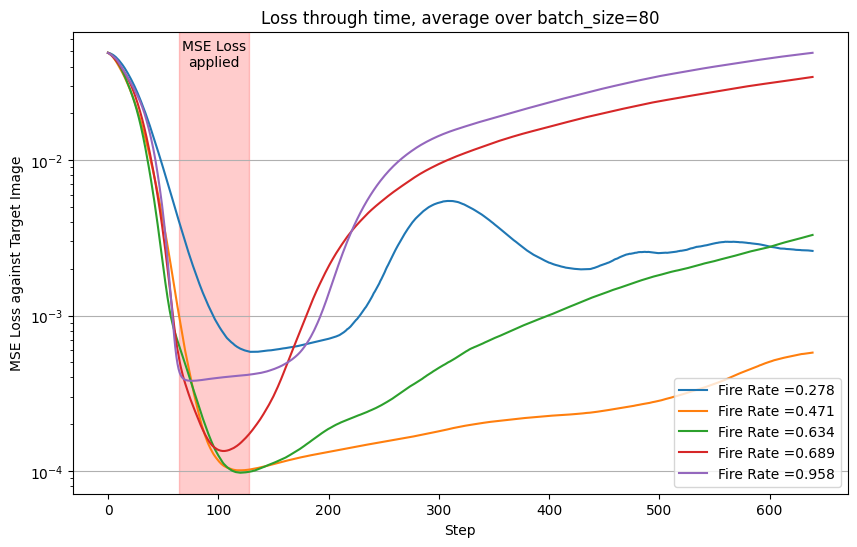

In [12]:
plt.figure(figsize=(10,6))
for data in ca_data:
    plt.plot(data["loss"], label="Fire Rate ={}".format(data["constFireRate"]))
    #plt.fill_between(np.arange(len(data["loss"])), data["loss"]-data["loss_stderror"], data["loss"]+data["loss_stderror"], alpha=0.2)
plt.axvspan(global_params["MIN_STEPS"], global_params["MAX_STEPS"], alpha=0.2, color='red')
plt.text(96, 4e-2, "MSE Loss\napplied", fontsize=10, horizontalalignment='center')

plt.legend()
plt.title(f"Loss through time, average over batch_size={number_of_batches*training_params['batch_size']}")
plt.yscale('log')
plt.ylabel("MSE Loss against Target Image")
plt.xlabel("Step")
plt.grid(axis='y')
#plt.ylim([0,0.1])
plt.show()

## CA vs EnergyCA comparison plots

/tmp/ipykernel_1695533/363309644.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2, i+1, sharey=plt.subplot(3,2, 1), sharex=plt.subplot(3,2, 1))


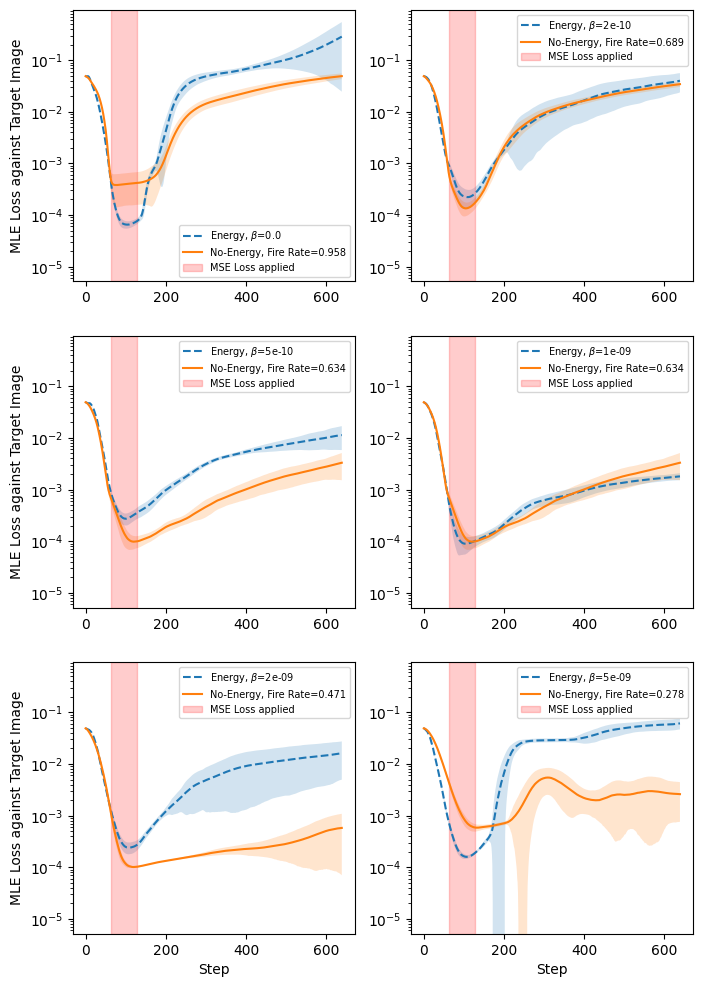

In [19]:
# for each betaEnergy, plot it's loss in the same plot as the loss of the corresponding constFireRate

plt.figure(figsize=(8,12))
for i, data in enumerate(energyca_data):
    # share y axis in subplots in same row, and share x axis in subplots in same column
    plt.subplot(3,2, i+1, sharey=plt.subplot(3,2, 1), sharex=plt.subplot(3,2, 1))

    # find corresponding ca_data
    data_ca = [data_ca for data_ca in ca_data if data_ca['constFireRate'] == beta_constFireRate_correspondance[data['betaEnergy']]][0]

    #plot in same axis
    plt.plot(data['loss'],'--', label=r"Energy, $\beta$={}".format(data['betaEnergy']))
    plt.fill_between(np.arange(len(data['loss'])), data['loss']-data['loss_stderror'], data['loss']+data['loss_stderror'], alpha=0.2)
    plt.plot(data_ca['loss'],'-', label="No-Energy, Fire Rate={}".format(data_ca['constFireRate']))
    plt.fill_between(np.arange(len(data_ca['loss'])), data_ca['loss']-data_ca['loss_stderror'], data_ca['loss']+data_ca['loss_stderror'], alpha=0.2)

    plt.axvspan(global_params["MIN_STEPS"], global_params["MAX_STEPS"], alpha=0.2, color='red', label="MSE Loss applied")

    if i in [0,2,4]:
        plt.ylabel("MLE Loss against Target Image")
    if i in [4,5]:
        plt.xlabel('Step')

    plt.yscale('log')
    plt.legend(fontsize=7)

In [24]:
# print final loss
for data in energyca_data:
    print("betaEnergy = {}, final loss = {}".format(data["betaEnergy"], data["loss"][-1]))
for data in ca_data:
    print("constFireRate = {}, final loss = {}".format(data["constFireRate"], data["loss"][-1]))

# print percentual difference between final loss of energyca and ca
for data in energyca_data:
    data_ca = [data_ca for data_ca in ca_data if data_ca['constFireRate'] == beta_constFireRate_correspondance[data['betaEnergy']]][0]
    print("betaEnergy = {}, percentual difference between final loss of energyca and ca = {}%".format(data["betaEnergy"], (data["loss"][-1]-data_ca["loss"][-1])*100/data_ca["loss"][-1]))

betaEnergy = 0.0, final loss = 0.2852978408336639
betaEnergy = 2e-10, final loss = 0.0399048887193203
betaEnergy = 5e-10, final loss = 0.0113406544551253
betaEnergy = 1e-09, final loss = 0.0017986722523346
betaEnergy = 2e-09, final loss = 0.0161783117800951
betaEnergy = 5e-09, final loss = 0.0612737312912941
constFireRate = 0.278, final loss = 0.00260676513426
constFireRate = 0.471, final loss = 0.0005782239022664
constFireRate = 0.634, final loss = 0.0033025641459971
constFireRate = 0.689, final loss = 0.0342678017914295
constFireRate = 0.958, final loss = 0.0490010939538478
betaEnergy = 0.0, percentual difference between final loss of energyca and ca = 4.822274929257185
betaEnergy = 2e-10, percentual difference between final loss of energyca and ca = 0.1645009785629335
betaEnergy = 5e-10, percentual difference between final loss of energyca and ca = 2.43389377277375
betaEnergy = 1e-09, percentual difference between final loss of energyca and ca = -0.45537098665753534
betaEnergy = 2e-

## CA vs EnergyCA damage comparison plots

/tmp/ipykernel_1695533/763635341.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3, i+1, sharey=plt.subplot(2,3, 1), sharex = plt.subplot(2,3, 4))


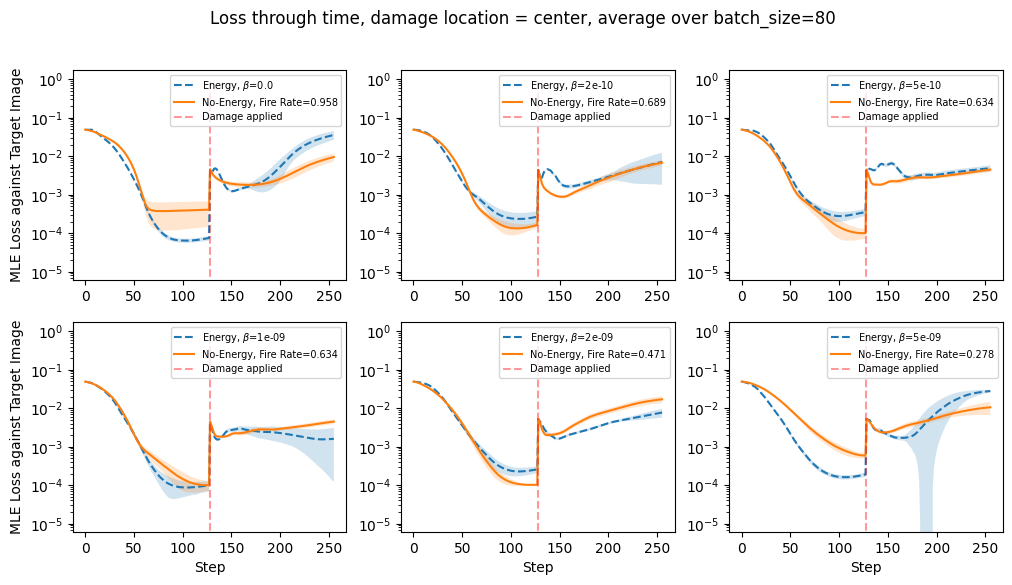

In [14]:
plt.figure(figsize=(12,6))
plt.suptitle(f"Loss through time, damage location = {damage_location}, average over batch_size={number_of_batches*training_params['batch_size']}")
for i, data in enumerate(energyca_damage_data):
    # share y axis in subplots in same row, and share x axis in subplots in same column
    plt.subplot(2,3, i+1, sharey=plt.subplot(2,3, 1), sharex = plt.subplot(2,3, 4))

    # find corresponding ca_data
    data_ca = [data_ca for data_ca in ca_damage_data if data_ca['constFireRate'] == beta_constFireRate_correspondance[data['betaEnergy']]][0]
    
    #plot in same axis
    plt.plot(data['loss'],'--', label=r"Energy, $\beta$={}".format(data['betaEnergy']))
    plt.fill_between(np.arange(len(data['loss'])), data['loss']-data['loss_stderror'], data['loss']+data['loss_stderror'], alpha=0.2)
    plt.plot(data_ca['loss'],'-', label="No-Energy, Fire Rate={}".format(data_ca['constFireRate']))
    plt.fill_between(np.arange(len(data_ca['loss'])), data_ca['loss']-data_ca['loss_stderror'], data_ca['loss']+data_ca['loss_stderror'], alpha=0.2)

    # vertical line at x = global_params["MAX_STEPS"]
    plt.vlines(global_params["MAX_STEPS"], 0, 1, colors='red', linestyles='dashed', label="Damage applied", alpha=0.4)
    
    if i in [0,3]:
        plt.ylabel("MLE Loss against Target Image")
    if i in [3,4,5]:
        plt.xlabel('Step')

    plt.yscale('log')
    plt.legend(fontsize=7)

In [60]:
debug("x0[0,36,36]")

x0[0,36,35] = tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


## Best EnergyCA model comparison plots

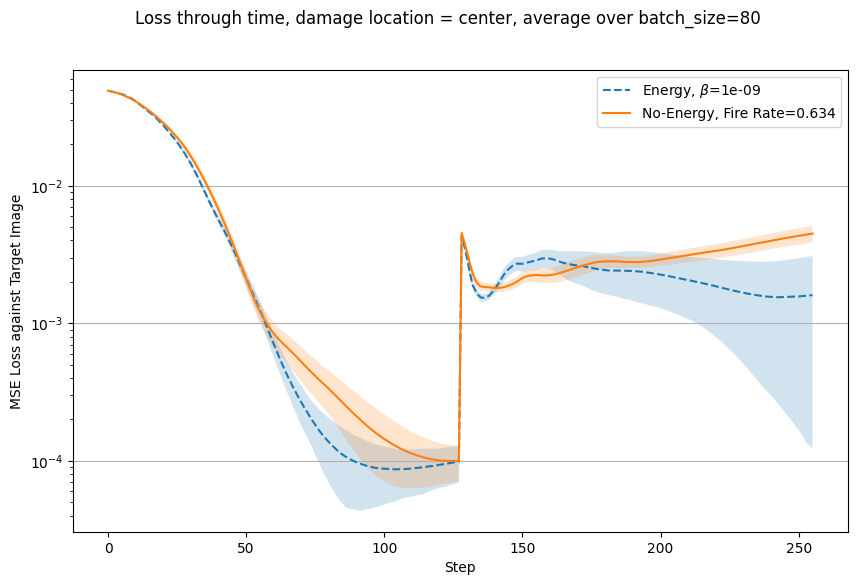

In [15]:
best_beta = 1e-9
energyca_loss = [data for data in energyca_damage_data if data["betaEnergy"] == best_beta][0]
ca_loss = [data for data in ca_damage_data if data["constFireRate"] == beta_constFireRate_correspondance[best_beta]][0]

plt.figure(figsize=(10,6))
plt.suptitle(f"Loss through time, damage location = {damage_location}, average over batch_size={number_of_batches*training_params['batch_size']}")

plt.plot(energyca_loss["loss"], '--', label=r"Energy, $\beta$={}".format(energyca_loss["betaEnergy"]))
plt.fill_between(np.arange(len(energyca_loss['loss'])), energyca_loss['loss']-energyca_loss['loss_stderror'], energyca_loss['loss']+energyca_loss['loss_stderror'], alpha=0.2)
plt.plot(ca_loss["loss"], '-', label = "No-Energy, Fire Rate={}".format(ca_loss['constFireRate']))
plt.fill_between(np.arange(len(ca_loss['loss'])), ca_loss['loss']-ca_loss['loss_stderror'], ca_loss['loss']+ca_loss['loss_stderror'], alpha=0.2)

plt.ylabel('MSE Loss against Target Image')
plt.xlabel('Step')
plt.yscale('log')
plt.grid(axis='y')
plt.legend()



**Missing Plots**
 - Final states for each damage
 - 1 evolution with damage for EnergyCA along with fireRates

# Load gumbel test model

In [ ]:
# Load model
max_steps = global_params['MAX_STEPS']*5
beta_energy = 1e-9
model_name = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/EnergyCA_gumbel_EnergyLoss_betaEnergy{beta_energy:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
model.load_state_dict(torch.load(model_name))
model.eval()


EnergyCAModel(
  (fc0): Linear(in_features=48, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=16, bias=False)
  (fireRate_layer): Linear(in_features=128, out_features=1, bias=True)
)

x_steps.shape = torch.Size([640, 8, 72, 72, 16])


/tmp/ipykernel_372774/2347808157.py:12: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]


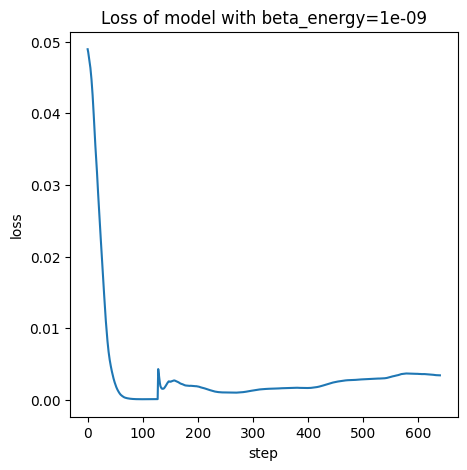

In [ ]:
# Run the model
with torch.no_grad():
    x_steps, fireRates_steps, update_grid_steps = model(x0, steps=max_steps, 
                                    damage_at_step=global_params["MAX_STEPS"], damage_location='center', damaged_in_batch=training_params["batch_size"],
                                    get_update_grid = True)

# compute the loss (mean accross the batch)
x_steps = x_steps.detach().cpu()
fireRates_steps = fireRates_steps.detach().cpu()
update_grid_steps = update_grid_steps.detach().cpu()
debug("x_steps.shape")
losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.title(f'Loss of model with beta_energy={beta_energy:.0e}')
plt.show()

In [13]:
debug("update_grid_steps.shape")

update_grid_steps.shape = torch.Size([640, 8, 72, 72])


In [14]:
# animate
animate_steps(
    to_rgb(x_steps),
    fireRates_steps,
    update_grid_steps,
)

# Persistance Test

## Gumbel models persistance test

In [7]:
# Load all models
beta_constFireRate_correspondance = {
    0: 0.958,
    1e-9: 0.634,
    #5e-9: 0.634,
    #2e-9: 0.471,
    #5e-10: 0.278,
    #2e-10: 0.689, ###
}

max_steps = global_params["MAX_STEPS"]*5
gumbel_dir = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(gumbel_dir)
model_names = [m for m in model_names if m.endswith('.pth') if float(m.split(param)[1].split('_')[0]) in beta_constFireRate_correspondance.keys()]
gumbel_models = [{} for _ in model_names]
param = 'betaEnergy'

for i,model in enumerate(gumbel_models):
    model['name'] = model_names[i]
    model[param] = float(model['name'].split(param)[1].split('_')[0])
    model['constFireRate'] = beta_constFireRate_correspondance[model['betaEnergy']]
    model['model'] = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
    model['model'].load_state_dict(torch.load(os.path.join(gumbel_dir, model['name'])))
    model['model'].name = model['name']
    model['model'].eval()

print("Loaded {} models from {}".format(len(gumbel_models), gumbel_dir))
print("betaEnergies: {}".format([m['betaEnergy'] for m in gumbel_models]))

Loaded 2 models from models/gumbel_maxSteps128/
betaEnergies: [0.0, 1e-09]


In [8]:
# Run the models
# Repeat number_of_batches times, to get better statistics

for m, model in enumerate(gumbel_models):
    x_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
    fireRates_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    update_grid_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    for i in range(number_of_batches):
        # clean previous print and replace with new one
        print(" "*100, end='\r')
        print(f"Running model {model['name']} batch {i+1}/{number_of_batches}", end='\r')
        with torch.no_grad():
            x_steps, fireRates_steps = model['model'](x0, steps=max_steps)

        x_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps.detach().cpu()
        fireRates_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = fireRates_steps.detach().cpu()
    model['x_steps'] = x_steps_batch
    model['fireRates_steps'] = fireRates_steps_batch
        

In [15]:

# Plot losses of all models through time, averaging over the batch
for i,model in enumerate(gumbel_models):
    model['loss'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    # compute average fireRate only for live cells (channel 3 > 0.1)
    model['avg_fireRate'] = [torch.mean(model['fireRates_steps'][k,:,:,:][model['x_steps'][k,:,:,:,3] > 0.1]).item() for k in range(max_steps)]
    model['loss_stderror'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]
    model['loss'] = np.array(model['loss'])
    model['avg_fireRate'] = np.array(model['avg_fireRate'])
    model['loss_stderror'] = np.array(model['loss_stderror'])
    


/tmp/ipykernel_68489/2255369537.py:3: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model['loss'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
/tmp/ipykernel_68489/2255369537.py:6: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model['loss_stderror'] = [F.mse_loss(model['x_steps'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]


In [16]:
# Save each loss to a .csv file, each file will have the name of the model.
# The 1st column is named "step" and the 2nd column is named "loss"

for model in gumbel_models:
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': model["loss"], 'loss_stderror': model["loss_stderror"], 'avg_fireRate':model["avg_fireRate"]})
    df.to_csv(os.path.join('test_losses',  model['name'].replace('.pth', '.csv')), index=False)

## Plots

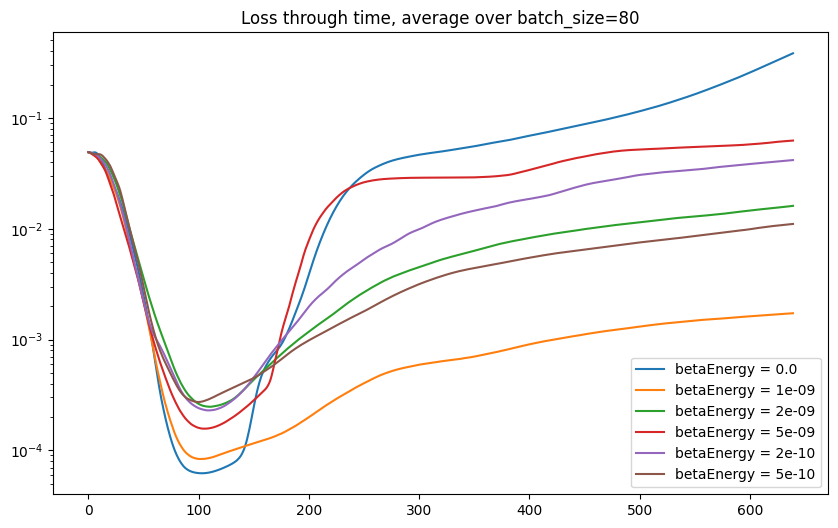

In [8]:
# plot the losses. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,6))
for model in gumbel_models:
    plt.plot(model['loss'], label="betaEnergy = {}".format(model['betaEnergy']))
    
plt.legend()
plt.title(f"Loss through time, average over batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
plt.yscale('log')
plt.show()



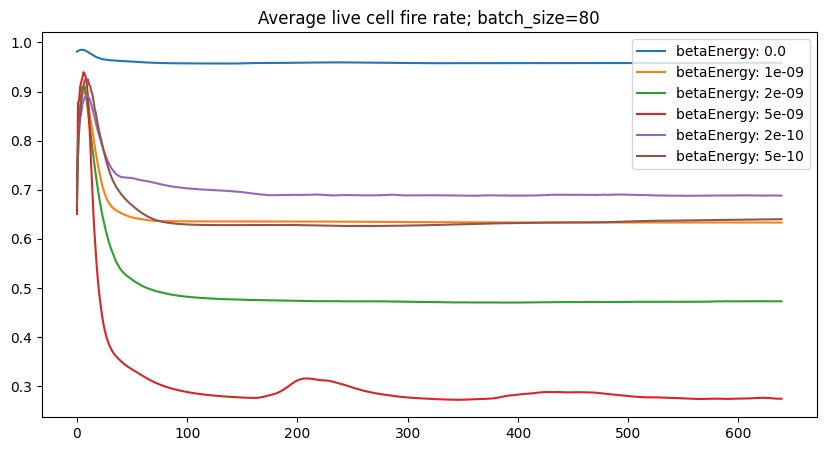

In [9]:
# plot the mean updates. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10,5))
for model in gumbel_models:
    plt.plot(model['avg_fireRate'], label="betaEnergy: {}".format(model['betaEnergy']))
    
plt.legend()
plt.title(f"Average live cell fire rate; batch_size={number_of_batches*training_params['batch_size']}")
#plt.ylim([0.0,0.06])
#plt.yscale('log')
plt.show()



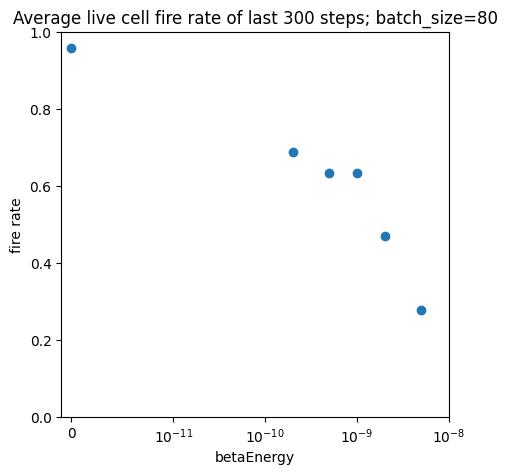

In [18]:
# plot the average firerate of the last 300 steps vs the beta energy
avg_fireRates_last = [np.mean(model['avg_fireRate'][-300:]) for model in gumbel_models]
plt.figure(figsize=(5,5))

plt.plot([model['betaEnergy'] for model in gumbel_models], avg_fireRates_last, 'o')
plt.title(f"Average live cell fire rate of last 300 steps; batch_size={number_of_batches*training_params['batch_size']}")
plt.xlabel("betaEnergy")
plt.ylabel("fire rate")
plt.xticks([0,1e-11,1e-10,1e-9,1e-8])
plt.xlim([-1e-12,1e-8])
plt.ylim([0,1])
plt.xscale('symlog', linthresh=1e-11)
plt.show()

In [19]:
print("Avg final fire rate of all models:")
for model in gumbel_models:
    print("betaEnergy: {}, avg fire rate: {:.3f}".format(model['betaEnergy'], np.mean(model['avg_fireRate'][-300:])))

Avg final fire rate of all models:
betaEnergy: 0.0, avg fire rate: 0.958
betaEnergy: 1e-09, avg fire rate: 0.633
betaEnergy: 2e-09, avg fire rate: 0.472
betaEnergy: 5e-09, avg fire rate: 0.279
betaEnergy: 2e-10, avg fire rate: 0.689
betaEnergy: 5e-10, avg fire rate: 0.635


Text(0.5, 0.98, 'Batch index = 7')

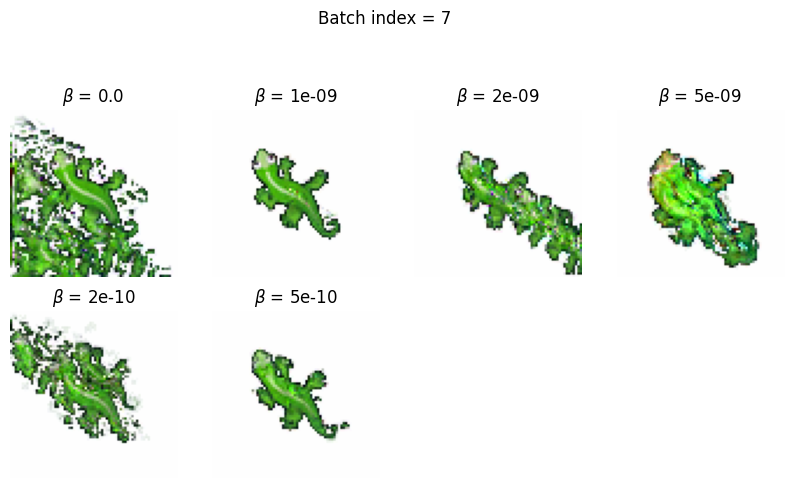

In [20]:
# Visualize a final state for each model in a grid
# Each model should have a label with the params used to train the model

# get the final state for each model
batch_i = np.random.randint(number_of_batches*training_params["batch_size"])

# plot the final state for each model
plt.figure(figsize=(10, 10))
for i,model in enumerate(gumbel_models):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_rgb(model['x_steps'][-1,batch_i]))
    plt.title(rf"$\beta$ = {model['betaEnergy']}")
    plt.axis('off')

plt.suptitle("Batch index = {}".format(batch_i))



model['betaEnergy'] = 0.0


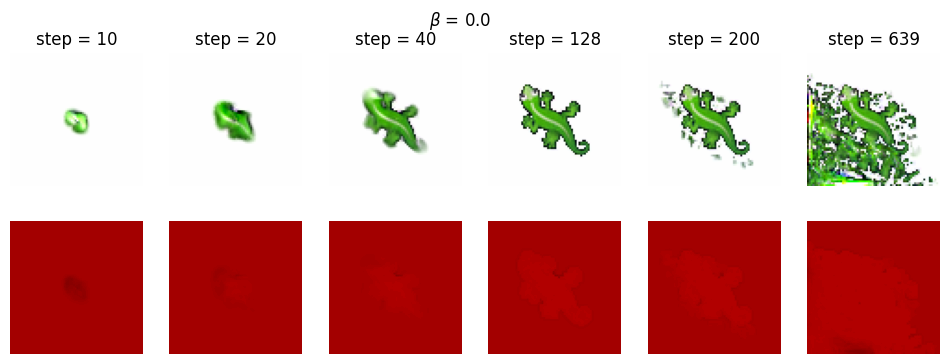

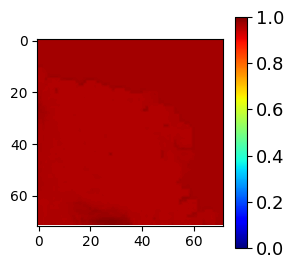

In [73]:
# Visualize for beta=1e-9 the x_steps and fireRates every 10 steps
plt.figure(figsize=(12, 4))
model = gumbel_models[0]
batch_i = 0
debug("model['betaEnergy']")
frames = [10,20,40,128, 200, 639]
plt.suptitle(r"$\beta$ = {}".format(model['betaEnergy']))

for i,frame in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title("step = {}".format(frame))
    plt.imshow(to_rgb(model['x_steps'][frame,batch_i]))
    plt.axis('off')
    plt.subplot(2, len(frames), i+1+len(frames))
    plt.imshow(model['fireRates_steps'][frame,batch_i], vmin=0, vmax=1, cmap='jet')
    plt.axis('off')

plt.figure(figsize=(3,3))
plt.imshow(model['fireRates_steps'][frame,batch_i], vmin=0, vmax=1, cmap='jet')
cbar = plt.colorbar()
tick_font_size = 13
cbar.ax.tick_params(labelsize=tick_font_size)


## Normal CA models persistence test

In [9]:
# Load all CA models
max_steps = global_params["MAX_STEPS"]*5
no_gumbel_dir = model_dir + f'no_gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(no_gumbel_dir)
param = 'constFireRate'
param_vals = [0.958, 0.634]###, 0.471, 0.278, 0.689] #values correspondent with final fireRates of EnergyCA models
model_names = [m for m in model_names if m.endswith('.pth') if float(m.split(param)[1].split('_')[0]) in param_vals]

models = [{} for i in range(len(param_vals))]

for i,model in enumerate(models):
    model['name'] = model_names[i]
    model[param] = float(model["name"].split(param)[1].split('_')[0])
    model['model'] = CAModel(global_params["CHANNEL_N"], fire_rate = model[param], device = training_params["device"])
    model['model'].load_state_dict(torch.load(os.path.join(no_gumbel_dir, model['name'])))
    model['model'].name = model['name']
    model['model'].eval()

print("Loaded {} models from {}".format(len(models), no_gumbel_dir))
print("constFireRates: {}".format([model[param] for model in models]))
                   

Loaded 2 models from models/no_gumbel_maxSteps128/
constFireRates: [0.634, 0.958]


In [10]:
# Run model for max_steps
for model in models:
    x_steps_total = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])

    for i in range(number_of_batches): 
        print(f"Running model {model['name']} for batch {i+1:02d}/{number_of_batches}", end='\r')

        x_steps = []
        update_grid_steps = []
        for j in range(max_steps):
            if j==0:
                x = x0
            with torch.no_grad():
                x = model['model'](x, steps=1)
            x_steps.append(x.detach().cpu())
        x_steps = torch.stack(x_steps)
        x_steps_total[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps

    model["x_steps"] = x_steps_total

debug("models[0]['x_steps'].shape")



models[0]['x_steps'].shape = torch.Size([640, 80, 72, 72, 16])pth for batch 10/10


In [35]:

# compute the loss (mean accross the batch) for each model
for model in models:
    model["loss"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    model["loss_stderror"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]
    model["loss"] = np.array(model["loss"])
    model["loss_stderror"] = np.array(model["loss_stderror"])



/tmp/ipykernel_397236/1337932119.py:3: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model["loss"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
/tmp/ipykernel_397236/1337932119.py:4: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model["loss_stderror"] = [F.mse_loss(model["x_steps"][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]


In [8]:
# save loss to csv, 1st column is the step, 2nd column is the loss, the file name has the model name
for model in models:
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': model["loss"], 'loss_stderror': model["loss_stderror"]})
    df.to_csv(os.path.join('test_losses',  model['name'].replace('.pth', '.csv')), index=False)

energyca_model['betaEnergy'] = 1e-09


Text(0.5, 1.0, 'Live cell count during lizard evolution')

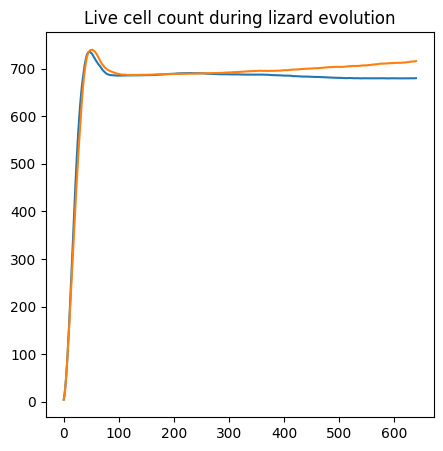

In [12]:
# Plot number of live cells (alpha channel > 0.1) against time
energyca_model = gumbel_models[1]
# corresponding ca model using beta correspondence
ca_model = [model for model in models if energyca_model['constFireRate'] == model['constFireRate']][0]

debug("energyca_model['betaEnergy']")
# count number of alive cells in x_steps
energyca_cell_counts = np.array([(energyca_model['x_steps'][k,:,:,:,3] > 0.1).sum(dim=[1,2]).float().mean() for k in range(max_steps)])
ca_cell_counts = np.array([(ca_model['x_steps'][k,:,:,:,3] > 0.1).sum(dim=[1,2]).float().mean() for k in range(max_steps)])
plt.figure(figsize=(5,5))
plt.plot(energyca_cell_counts, label="energyca_cell_counts")
plt.plot(ca_cell_counts, label="ca_cell_counts")

plt.title("Live cell count during lizard evolution")

energyca_model['betaEnergy'] = 1e-09


Text(0.5, 1.0, 'Energy consumption during lizard evolution')

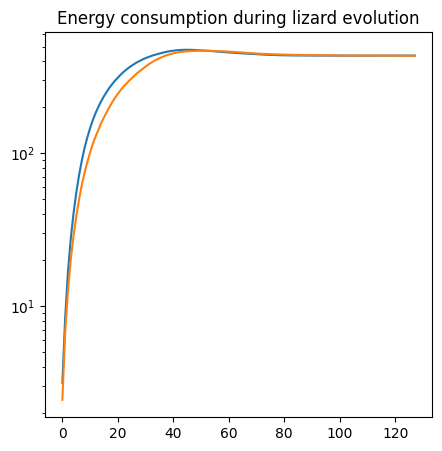

In [34]:
# compare total energy of live cells
final_step = global_params["MAX_STEPS"]
energyca_model = gumbel_models[1]
# corresponding ca model using beta correspondence
ca_model = [model for model in models if beta_constFireRate_correspondance[energyca_model['betaEnergy']] == model['constFireRate']][0]

debug("energyca_model['betaEnergy']")

# sum of all firerates of live cells in x_steps, averaged across batch
energyca_fireRate_sum= np.array([energyca_model['fireRates_steps'][k,:,:,:][energyca_model['x_steps'][k,:,:,:,3] > 0.1].sum()/(training_params['batch_size']*number_of_batches) for k in range(max_steps)])
ca_fireRate_sum = np.array([(ca_model['x_steps'][k,:,:,:,3] > 0.1).sum()*ca_model['constFireRate']/(training_params['batch_size']*number_of_batches) for k in range(max_steps)])
plt.figure(figsize=(5,5))
plt.plot(energyca_fireRate_sum[:final_step], label="energyca_fireRate_sum")
plt.plot(ca_fireRate_sum[:final_step], label="ca_fireRate_sum")
plt.yscale('log')

plt.title("Energy consumption during lizard evolution")

# Damage resistance

## Gumbel models

In [64]:
# Load all models
beta_constFireRate_correspondance = {
    0: 0.958,
    1e-9: 0.634,
    #5e-9: 0.634,
    #2e-9: 0.471,
    #5e-10: 0.278,
    #2e-10: 0.689, ###
}
max_steps = global_params["MAX_STEPS"]*2
gumbel_dir = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(gumbel_dir)
model_names = [m for m in model_names if m.endswith('.pth') if float(m.split('betaEnergy')[1].split('_')[0]) in beta_constFireRate_correspondance.keys()]
gumbel_models = [{} for _ in model_names]
param = 'betaEnergy'

for i,model in enumerate(gumbel_models):
    model['name'] = model_names[i]
    model[param] = float(model['name'].split(param)[1].split('_')[0])
    model['constFireRate'] = beta_constFireRate_correspondance[model['betaEnergy']]
    model['model'] = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
    model['model'].load_state_dict(torch.load(os.path.join(gumbel_dir, model['name'])))
    model['model'].name = model['name']
    model['model'].eval()

print("Loaded {} models from {}".format(len(gumbel_models), gumbel_dir))
print("betaEnergies: {}".format([m['betaEnergy'] for m in gumbel_models]))
# Damage params
damage_at_step= global_params["MAX_STEPS"]
damage_location='center' #['random', 'center'x, 'head'x, 'leg1'x, 'tail'x] 
damaged_in_batch= training_params["batch_size"]
                   

Loaded 2 models from models/gumbel_maxSteps128/
betaEnergies: [0.0, 1e-09]


In [65]:
# Run the models
# Repeat number_of_batches times, to get better statistics
for m, model in enumerate(gumbel_models):
    x_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])
    fireRates_steps_batch = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:3])
    
    for i in range(number_of_batches):
        # clean previous print and replace with new one
        print(" "*100, end='\r')
        print(f"Running model {model['name']} batch {i+1}/{number_of_batches}", end='\r')
        with torch.no_grad():
            x_steps, fireRates_steps = model["model"](x0, steps=max_steps,
                                             damage_at_step=damage_at_step, damage_location=damage_location, 
                                             damaged_in_batch=damaged_in_batch)

        x_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps.detach().cpu()
        fireRates_steps_batch[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = fireRates_steps.detach().cpu()
    
    model[f"x_steps_{damage_location}"] = x_steps_batch
    model[f"fireRates_steps_{damage_location}"] = fireRates_steps_batch


        

In [66]:
debug(f"gumbel_models[-1]['x_steps_{damage_location}'].shape")

gumbel_models[-1]['x_steps_center'].shape = torch.Size([256, 80, 72, 72, 16])


In [67]:

# Plot losses of all models through time, averaging over the batch
for i,model in enumerate(gumbel_models):
    model[f'loss_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    # compute average fireRate only for live cells (channel 3 > 0.1)
    model[f'avg_fireRate_{damage_location}'] = [torch.mean(model[f'fireRates_steps_{damage_location}'][k,:,:,:][model[f'x_steps_{damage_location}'][k,:,:,:,3] > 0.1]).item() for k in range(max_steps)]
    model[f'loss_stderror_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]
    model[f'loss_{damage_location}'] = np.array(model[f'loss_{damage_location}'])
    model[f'avg_fireRate_{damage_location}'] = np.array(model[f'avg_fireRate_{damage_location}'])
    model[f'loss_stderror_{damage_location}'] = np.array(model[f'loss_stderror_{damage_location}'])


/tmp/ipykernel_1413453/468527934.py:3: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model[f'loss_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
/tmp/ipykernel_1413453/468527934.py:6: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model[f'loss_stderror_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]


np.log10(gumbel_models[-1]["loss_center"][-1]) = -2.7575771652009875
gumbel_models[-1]["loss_center"][-1] = 0.0017475227359682322


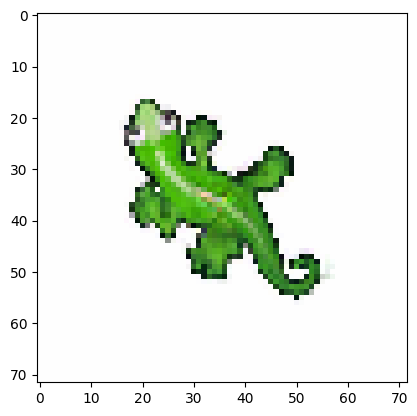

In [74]:
plt.imshow(to_rgb(gumbel_models[-1][f'x_steps_{damage_location}'][-1,5,:,:,:4].numpy()))
debug(f'np.log10(gumbel_models[-1]["loss_{damage_location}"][-1])', f'gumbel_models[-1]["loss_{damage_location}"][-1]')

model['betaEnergy'] = 1e-09


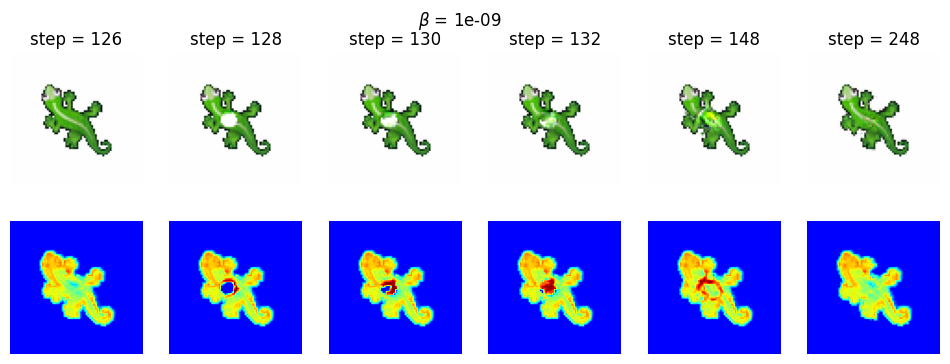

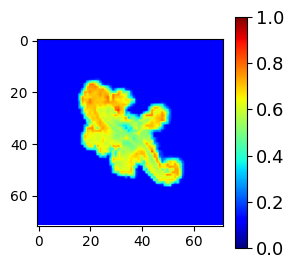

In [89]:
# Visualize for beta=1e-9 the x_steps and fireRates every 10 steps
plt.figure(figsize=(12, 4))
model = gumbel_models[1]
batch_i = 5
debug("model['betaEnergy']")
frames = [126, 128, 130, 132, 148, 248]
plt.suptitle(r"$\beta$ = {}".format(model['betaEnergy']))

for i,frame in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title("step = {}".format(frame))
    plt.imshow(to_rgb(model[f'x_steps_{damage_location}'][frame,batch_i]))
    plt.axis('off')
    plt.subplot(2, len(frames), i+1+len(frames))
    plt.imshow(model[f'fireRates_steps_{damage_location}'][frame,batch_i], vmin=0, vmax=1, cmap='jet')
    plt.axis('off')

plt.figure(figsize=(3,3))
plt.imshow(model[f'fireRates_steps_{damage_location}'][frame,batch_i], vmin=0, vmax=1, cmap='jet')
cbar = plt.colorbar()
tick_font_size = 13
cbar.ax.tick_params(labelsize=tick_font_size)

In [29]:
# Save each loss to a .csv file, each file will have the name of the model.
# The 1st column is named "step" and the 2nd column is named "loss"
print("Saving losses to .csv files of damage_location:{}".format(damage_location))
for model in gumbel_models:
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': model[f'loss_{damage_location}'], 'avg_fireRate': model[f'avg_fireRate_{damage_location}'], 'loss_stderror': model[f'loss_stderror_{damage_location}']})
    df.to_csv(os.path.join(f'damage_losses/{damage_location}',  model['name'].replace('.pth', '.csv')), index=False)

Saving losses to .csv files of damage_location:leg1


## Normal CA model (for damage)

In [75]:
# Load all CA models
max_steps = global_params["MAX_STEPS"]*2
no_gumbel_dir = model_dir + f'no_gumbel_maxSteps{global_params["MAX_STEPS"]}/'
model_names = os.listdir(no_gumbel_dir)
param = 'constFireRate'
param_vals = [0.958, 0.634]#, 0.471, 0.278, 0.689] #values correspondent with final fireRates of EnergyCA models
model_names = [m for m in model_names if m.endswith('.pth') if float(m.split(param)[1].split('_')[0]) in param_vals]

models = [{} for i in range(len(param_vals))]

for i,model in enumerate(models):
    model['name'] = model_names[i]
    model[param] = float(model["name"].split(param)[1].split('_')[0])
    model['model'] = CAModel(global_params["CHANNEL_N"], fire_rate = model[param], device = training_params["device"])
    model['model'].load_state_dict(torch.load(os.path.join(no_gumbel_dir, model['name'])))
    model['model'].name = model['name']
    model['model'].eval()

print("Loaded {} models from {}".format(len(models), no_gumbel_dir))
print("constFireRates: {}".format([model[param] for model in models]))

# Damage params
damage_at_step= global_params["MAX_STEPS"]
damage_location='center' #['random', 'center'x, 'head'x, 'leg1'x, 'tail'x] 
damaged_in_batch= training_params["batch_size"]

Loaded 2 models from models/no_gumbel_maxSteps128/
constFireRates: [0.634, 0.958]


In [76]:
# Run model for max_steps
print("Damage location = ", damage_location)
for model in models:
    x_steps_total = torch.zeros((max_steps, number_of_batches*training_params["batch_size"],) + x0.shape[1:])

    for i in range(number_of_batches): 
        print(f"Running model {model['name']} for batch {i+1:02d}/{number_of_batches}", end='\r')

        x_steps = []
        update_grid_steps = []
        for j in range(max_steps):
            if j==0:
                x = x0
            if j==damage_at_step:
                x = damage_batch(x, 
                                training_params["device"],
                                img_size = 72, 
                                damage_location = damage_location, damaged_in_batch = damaged_in_batch)
            with torch.no_grad():
                x = model['model'](x, steps=1)
            x_steps.append(x.detach().cpu())
        x_steps = torch.stack(x_steps)
        x_steps_total[:, i*training_params["batch_size"]:(i+1)*training_params["batch_size"], ...] = x_steps

    model[f"x_steps_{damage_location}"] = x_steps_total


Damage location =  center


In [77]:
# Losses of all models through time, averaging over the batch
for i,model in enumerate(models):
    model[f'loss_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
    # compute average fireRate only for live cells (channel 3 > 0.1)
    model[f'loss_stderror_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]
    model[f'loss_{damage_location}'] = np.array(model[f'loss_{damage_location}'])
    model[f'loss_stderror_{damage_location}'] = np.array(model[f'loss_stderror_{damage_location}'])

/tmp/ipykernel_1413453/3063285210.py:3: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model[f'loss_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target).item() for k in range(max_steps)]
/tmp/ipykernel_1413453/3063285210.py:5: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([80, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  model[f'loss_stderror_{damage_location}'] = [F.mse_loss(model[f'x_steps_{damage_location}'][k,:,:,:,:4], pad_target, reduction='none').mean(dim=[1,2,3]).std().item() for k in range(max_steps)]


np.log10(models[0]["loss_center"][-1]) = -2.358318966401417
models[0]["loss_center"][-1] = 0.004382087383419275


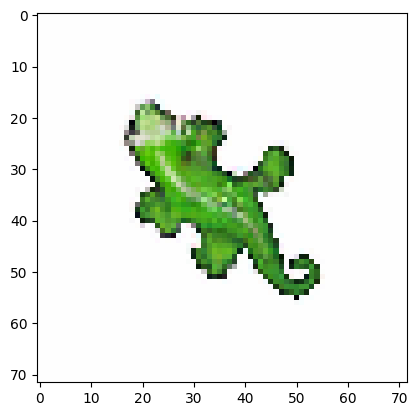

In [81]:
plt.imshow(to_rgb(models[0][f'x_steps_{damage_location}'][-1,4,:,:,:4].numpy()))
debug(f'np.log10(models[0]["loss_{damage_location}"][-1])', f'models[0]["loss_{damage_location}"][-1]')

Text(0.5, 1.0, 'Target')

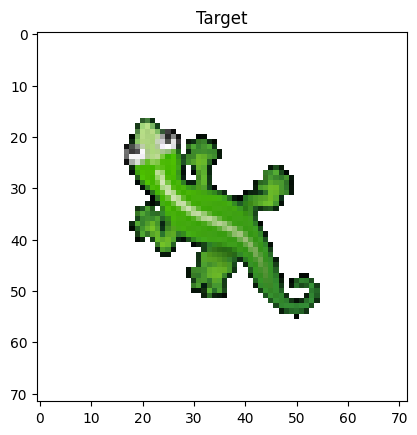

In [58]:
plt.imshow(pad_target[0])
plt.title("Target")

In [36]:
# Save each loss to a .csv file, each file will have the name of the model.
# The 1st column is named "step" and the 2nd column is named "loss"
print("Saving losses to .csv files of damage_location:{}".format(damage_location))
for model in models:
    df = pd.DataFrame({'step': list(range(max_steps)), 'loss': model[f'loss_{damage_location}'], 'loss_stderror': model[f'loss_stderror_{damage_location}']})
    df.to_csv(os.path.join(f'damage_losses/{damage_location}',  model['name'].replace('.pth', '.csv')), index=False)

Saving losses to .csv files of damage_location:head


# Test IncrementalEnergyCA

Loaded model  models/gumbel_maxSteps128/IncrementalEnergyCA_gumbel_EnergyLoss_variablebetaEnergy1e-09_maxSteps128_epoch10000.pth
x_steps.shape = torch.Size([640, 8, 72, 72, 16])


/tmp/ipykernel_608960/4277529964.py:25: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]


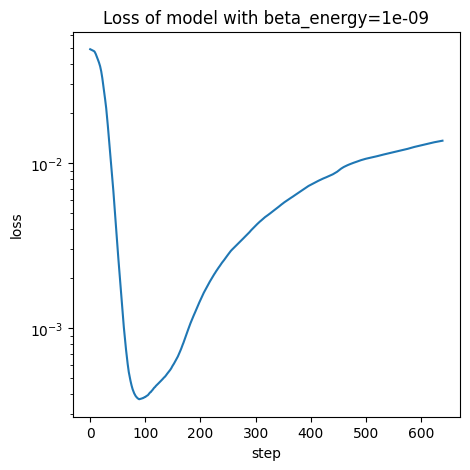

In [4]:
# Load model
from lib.IncrementalEnergyCAModel import IncrementalEnergyCAModel

max_steps = global_params['MAX_STEPS']*5
beta_energy = 1e-9
model_name = model_dir + f'gumbel_maxSteps{global_params["MAX_STEPS"]}/IncrementalEnergyCA_gumbel_EnergyLoss_variablebetaEnergy{beta_energy:.0e}_maxSteps{global_params["MAX_STEPS"]}_epoch{training_params["n_epoch"]}.pth'
model = IncrementalEnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
model.load_state_dict(torch.load(model_name))
model.eval()
print("Loaded model ", model_name)

damage_at_step = -1 # global_params["MAX_STEPS"]
damage_location = 'center' #['random', 'center', 'head', 'leg1', 'tail']
# Run the model
with torch.no_grad():
    x_steps, fireRates_steps = model(x0, steps=max_steps, 
                                    damage_at_step=damage_at_step, 
                                    damage_location=damage_location, 
                                    damaged_in_batch=training_params["batch_size"])

# compute the loss (mean accross the batch)
x_steps = x_steps.detach().cpu()
fireRates_steps = fireRates_steps.detach().cpu()
debug("x_steps.shape")
losses = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)).item() for k in range(max_steps)]

# plot the loss
plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.title(f'Loss of model with beta_energy={beta_energy:.0e}')
plt.show()

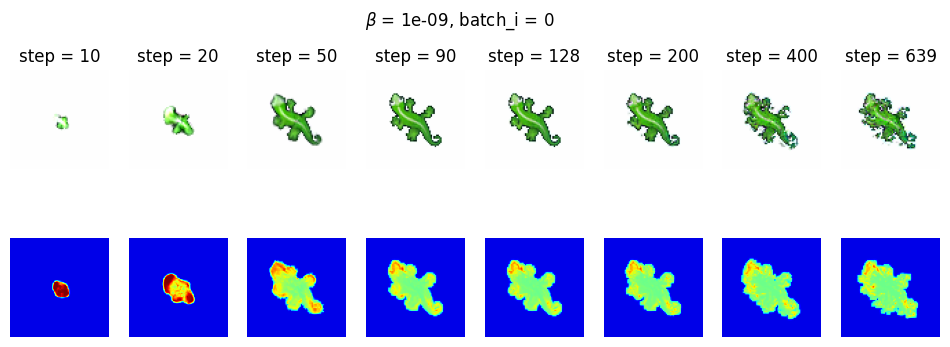

In [5]:
# Visualize for beta=1e-9 the x_steps and fireRates
plt.figure(figsize=(12, 4))
batch_i = np.random.randint(training_params["batch_size"])
frames = [10,20,50,90,128,200,400,639]#[128,130,132,134,138,200, 250]#
plt.suptitle(r"$\beta$ = {}, batch_i = {}".format(beta_energy, batch_i))

for i,frame in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title("step = {}".format(frame))
    plt.imshow(to_rgb(x_steps[frame,batch_i]))
    plt.axis('off')
    plt.subplot(2, len(frames), i+1+len(frames))
    plt.imshow(fireRates_steps[frame,batch_i], vmin=0, vmax=1, cmap='jet')
    plt.axis('off')

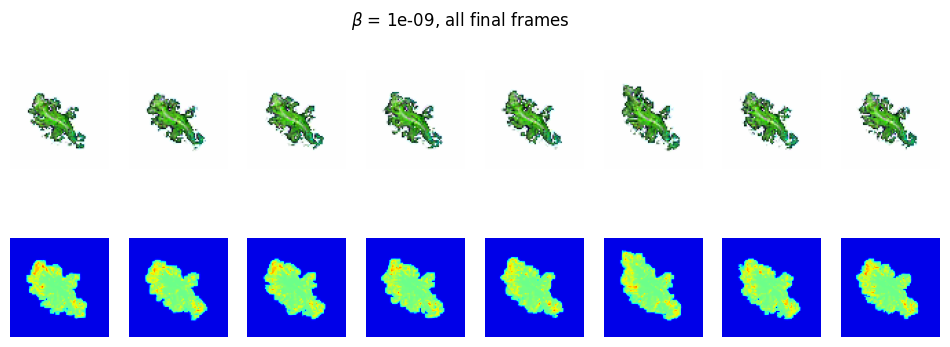

In [6]:
# Visualize all final frames of batch
plt.figure(figsize=(12, 4))
plt.suptitle(r"$\beta$ = {}, all final frames".format(beta_energy))
for i in range(x_steps.shape[1]):
    plt.subplot(2, x_steps.shape[1], i+1)
    plt.imshow(to_rgb(x_steps[-1,i]))
    plt.axis('off')
    plt.subplot(2, x_steps.shape[1], i+1+x_steps.shape[1])
    plt.imshow(fireRates_steps[-1,i], vmin=0, vmax=1, cmap='jet')
    plt.axis('off')


In [7]:
animate_steps(
    to_rgb(x_steps),
    fireRates_steps,
)